In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import keras_tuner

train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
val_data = pd.read_csv('val_data.csv')

In [2]:
patv_train = train_data['Patv'].tolist()
patv_test = test_data['Patv'].tolist()
patv_val= val_data['Patv'].tolist()
df_train = train_data.drop(['Patv'],axis=1)
df_test = test_data.drop(['Patv'],axis=1)
df_val=val_data.drop(['Patv'],axis=1)

In [3]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)


In [4]:
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,patv_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,patv_test)
x_val,y_val = to_sequences(SEQUENCE_SIZE,patv_val)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))
print("Shape of validation set: {}".format(x_val.shape))

Shape of training set: (2836502, 10, 1)
Shape of test set: (945494, 10, 1)
Shape of validation set: (945494, 10, 1)


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [6]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


In [7]:
input_shape = x_train.shape[1:]
mlp_units=[128]

def create_model(hp):
    hp_head_size = 128
    hp_num_heads = 4
    hp_ff_dim = 16
    hp_num_transformer_blocks = 6
    hp_dropout = 0.2
    hp_mlp_dropout = 0.3
    hp_learning_rate = 1e-4
    
    model = build_model(
        input_shape,
        head_size=hp_head_size,
        num_heads=hp_num_heads,
        ff_dim=hp_ff_dim,
        num_transformer_blocks=hp_num_transformer_blocks,
        mlp_units=mlp_units,
        dropout=hp_dropout,
        mlp_dropout=hp_mlp_dropout,
    )
    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    )
    return model

In [8]:
tuner = keras_tuner.RandomSearch(
    create_model,
    objective='val_loss',
    overwrite=True,
    max_trials=1)

tuner.search(x_train,y_train , epochs=25, validation_data=(x_val, y_val))

Trial 1 Complete [16h 02m 16s]
val_loss: 11021.337890625

Best val_loss So Far: 11021.337890625
Total elapsed time: 16h 02m 16s
INFO:tensorflow:Oracle triggered exit


In [9]:
best_model = tuner.get_best_models()[0]
print(tuner.results_summary(num_trials=1))

Results summary
Results in .\untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
default configuration
Score: 11021.337890625
None


In [10]:
# model.evaluate(x_test, y_test, verbose=1)

# from sklearn import metrics

# pred = model.predict(x_test)
# score = np.sqrt(metrics.mean_squared_error(pred,y_test))
# print("Score (RMSE): {}".format(score))

29547/29547 [==============================] - 248s 8ms/step


(        Predictions  Actuals
 0         61.253624    55.13
 1         61.253624    55.13
 2         61.253624    55.13
 3         61.253624    55.13
 4         61.253624    55.13
 ...             ...      ...
 945489   811.097839   601.44
 945490   582.576111   673.79
 945491   669.370972   999.36
 945492   969.170105  1100.89
 945493  1052.929932  1181.49
 
 [945494 rows x 2 columns],
 11785.650213771876)

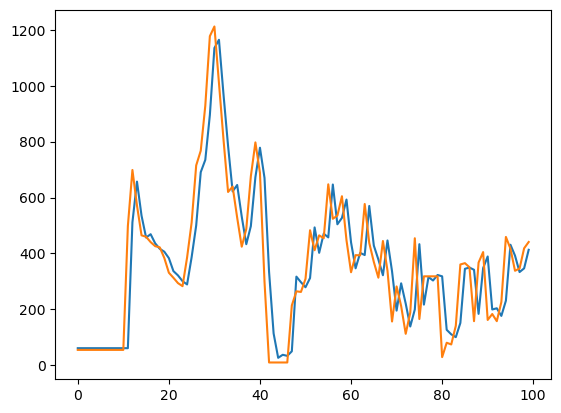

In [11]:
from sklearn.metrics import mean_squared_error as mse
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

plot_predictions1(best_model, x_test, y_test)

In [12]:
y_p = best_model.predict(x_test)

# convert array into dataframe
DF = pd.DataFrame(y_p)

# save the dataframe as a csv file
DF.to_csv("Transformer_Output.csv")

29547/29547 [==============================] - 408s 14ms/step
